## Attribution de prêt bancaire
Simplonline : https://simplonline.co/briefs/fce27a79-47ba-4968-9553-24befdd92376 <br>
Repo : None

***Contexte du projet*** <br>
Vous devez donc créer un outil d'aider à la décision à destination des banquiers qui doivent gérer l'attribution des prêts. Evidemment, le Crédit Simplonien s'attend à un outil extrêment efficace avec un forte précision et un risque d'erreur proche de 0.

Le banquier n'est pas un expert Data, mais il devra être capable de justifier les résultats de l'outil que vous lui mettrez à disposition grâce notamment au document synthétique explicatif.

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report
from tpot import TPOTClassifier

In [2]:
def clean_df(df):
    df = df.dropna()
    df = df.drop('Loan_ID', axis=1)
    df['Loan_Status'] = df['Loan_Status'].replace(['N', 'Y'], [0, 1])
    return df

In [3]:
train_df = pd.read_csv('./train.txt')
test_df = pd.read_csv('./test.txt')

In [4]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.00,nan,360.00,1.00,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.00,128.00,360.00,1.00,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.00,66.00,360.00,1.00,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.00,120.00,360.00,1.00,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.00,141.00,360.00,1.00,Urban,Y


In [5]:
train_df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [6]:
# Perfom all necessery modification on the given dataset
train_df = clean_df(train_df)

In [8]:
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

In [9]:
X = train_df[categorical_features + numeric_features]
y = train_df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

-----
#### Baseline - Lazy preddict classifier

In [ ]:
lazy_clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)

In [12]:
models[models['Balanced Accuracy'] > 0.75]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.85,0.77,0.77,0.84,0.04
LinearDiscriminantAnalysis,0.85,0.77,0.77,0.84,0.02
BaggingClassifier,0.79,0.77,0.77,0.79,0.03
LogisticRegression,0.84,0.76,0.76,0.83,0.02
RidgeClassifier,0.85,0.76,0.76,0.83,0.02
CalibratedClassifierCV,0.85,0.76,0.76,0.83,0.09
NearestCentroid,0.85,0.76,0.76,0.83,0.02
GaussianNB,0.83,0.76,0.76,0.82,0.02
LGBMClassifier,0.81,0.76,0.76,0.80,0.05


-----
#### Model selection

In [17]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

In [18]:
# Preprocessing categorical features
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Preprocessing numeric features
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

In [19]:
knn_clf = KNN()
adaBoost_clf = AdaBoostClassifier() 
logReg_clf = LogisticRegression()
bernoulli_clf = BernoulliNB()
linearSVC_clf = LinearSVC()

model_selection = [knn_clf, adaBoost_clf, logReg_clf, bernoulli_clf, linearSVC_clf]

for x in model_selection:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', x)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    print(f'{x} results :\n')
    print(classification_report(y_pred, y_test))
    print('\n')

KNeighborsClassifier() results :

              precision    recall  f1-score   support

           0       0.64      0.49      0.55        57
           1       0.71      0.82      0.76        87

    accuracy                           0.69       144
   macro avg       0.67      0.65      0.66       144
weighted avg       0.68      0.69      0.68       144



AdaBoostClassifier() results :

              precision    recall  f1-score   support

           0       0.73      0.62      0.67        52
           1       0.80      0.87      0.83        92

    accuracy                           0.78       144
   macro avg       0.76      0.74      0.75       144
weighted avg       0.77      0.78      0.77       144



LogisticRegression() results :

              precision    recall  f1-score   support

           0       0.66      0.53      0.59        55
           1       0.74      0.83      0.78        89

    accuracy                           0.72       144
   macro avg       0.70   

-----
#### Model tuning - AdaBoost

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

In [21]:
params = {
    'clf__n_estimators': [50, 100, 150, 200]
}

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', adaBoost_clf)
    ])

AdaGrid_clf = GridSearchCV(pipe, params)
AdaGrid_clf.fit(X_train, y_train)
y_pred = AdaGrid_clf.predict(X_test)
    
print('AdaBoost GridSearchCV results :\n')
print('Best params :', AdaGrid_clf.best_params_)
print('\n')
print(classification_report(y_pred, y_test))
print('\n')

AdaBoost GridSearchCV results :

Best params : {'clf__n_estimators': 50}


              precision    recall  f1-score   support

           0       0.73      0.62      0.67        52
           1       0.80      0.87      0.83        92

    accuracy                           0.78       144
   macro avg       0.76      0.74      0.75       144
weighted avg       0.77      0.78      0.77       144





In [31]:
train_sizes, train_scores, test_scores = learning_curve(pipe, X_train, y_train, cv=20)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

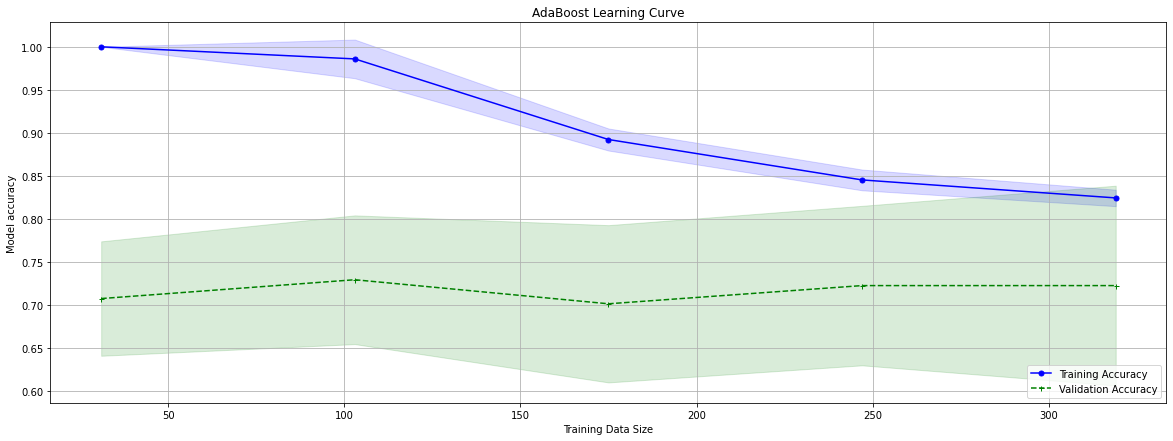

In [35]:
plt.figure(figsize=(20,7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('AdaBoost Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()